In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
%run main

/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
model_names

['prednet_original']

In [4]:
from fastai.core import *
torch.cuda.set_device(2)

### Is moving variable out of GPU before taking backward step even possible?

In [ ]:
n_hidden = 10
vocab_size = 6

In [32]:
class CharLoopModel(nn.Module):
    # This is an RNN!
#     def __init__(self, vocab_size, n_fac):
    def __init__(self, n_fac):
        super().__init__()
#         self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            c = c.cuda()
            inp = F.relu(self.l_in(c))
            c = c.cpu()
            h = F.tanh(self.l_hidden(h+inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [40]:
model = CharLoopModel(7).cuda()

In [41]:
opt = optim.Adam(model.parameters(), lr=1e-2)

In [42]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 5, 7, n_hidden, vocab_size

# Create random Tensors to hold input and outputs
x = V(torch.randn(N, D_in), requires_grad=True)
y = V(torch.randn(N, D_out), requires_grad=True)

In [43]:
x = x.cpu()

In [44]:
x[0,0]

Variable containing:
-0.7435
[torch.FloatTensor of size 1]

In [45]:
for epoch in range(100):
    y_p = model(x)
    loss = torch.sum(y - y_p);
    print(loss.data[0])
    model.zero_grad()
    loss.backward()
    opt.step()

50.0873908996582
49.810035705566406
49.6632194519043
49.6053581237793
49.586341857910156
49.57242202758789
49.554710388183594
49.5361442565918
49.52169418334961
49.51423263549805
49.512840270996094
49.513587951660156
49.513092041015625
49.50983810424805
49.50430679321289
49.497657775878906
49.491703033447266
49.4878044128418
49.48635482788086
49.48702621459961
49.488929748535156
49.4909782409668
49.4923095703125
49.49248123168945
49.491554260253906
49.48992919921875
49.488101959228516
49.48651123046875
49.485382080078125
49.48476028442383
49.484554290771484
49.484580993652344
49.484683990478516
49.484737396240234
49.484710693359375
49.4846076965332
49.48446273803711
49.484310150146484
49.484153747558594
49.48397445678711
49.48374938964844
49.48346710205078
49.48319625854492
49.48296356201172
49.48281478881836
49.48276901245117
49.482810974121094
49.48288345336914
49.48292541503906
49.48291778564453
49.48284149169922
49.48271560668945
49.482574462890625
49.48247528076172
49.482406616210

Yeah, it is possible

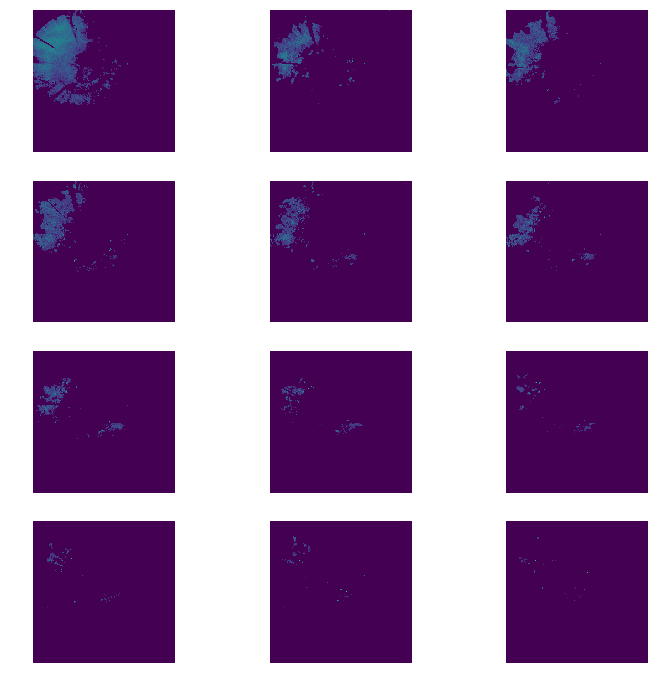

In [8]:
plots(inputs, vmin=torch.min(inputs), vmax=torch.max(inputs))

### Model

In [1]:
%run main

/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zyc/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
torch.cuda.set_device(2)
model = models.__dict__['prednet_original']().cuda()

# use DDP here

In [3]:
md, trn_sampler = torch_loader('../data/SRAD2018/', 1, 1, 256, debug=True, zero_missing=True)
crit = nn.L1Loss().cuda()
opt = optim.SGD(model.parameters(), 0.01)

In [4]:
md_iter = iter(md.trn_dl)
inputs, target = next(md_iter)
inputs, target = V(inputs), V(target)
print(inputs.shape, target.shape)

torch.Size([5, 12, 1, 256, 256]) torch.Size([5, 12])


In [5]:
pred = model(V(inputs))
type(pred), pred.shape

(torch.autograd.variable.Variable, torch.Size([5, 4, 12]))

In [6]:
error = pred[:,0]

In [8]:
crit(error, target)

Variable containing:
 0.1863
[torch.cuda.FloatTensor of size 1 (GPU 2)]

In [7]:
def train(md, model, criterion, optimizer, epoch):
    model.train()
    
    md_iter = iter(md.trn_dl)
    inputs, target = next(md_iter)
    
    for i, (inputs, target) in enumerate(iter(md.trn_dl)):
        
        input_var = Variable(inputs)
        target_var = Variable(target)
        
        output = model(input_var)
        output = output[:,0] # only calculate gradient on the error of the first layer
        loss = criterion(output, target_var)
        print(i, loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [ ]:
train(md, model, crit, opt, 1)

0 0.033992134034633636
1 0.03635501116514206
2 0.03791160508990288
3 0.03755488246679306
4 0.0349629782140255
5 0.037176862359046936
6 0.03480571508407593
7 0.035175442695617676
8 0.03628058359026909


Great! Worked. Now use the fastai library

In [6]:
children(model)

[ConvLSTMCell(
 ), ConvLSTMCell(
 ), ConvLSTMCell(
 ), ConvLSTMCell(
 ), Sequential(
   (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU()
   (satlu): SatLU (min_val=0, max_val=255)
 ), Sequential(
   (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU()
 ), Upsample(scale_factor=2, mode=nearest), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False), Sequential(
   (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
 ), Sequential(
   (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=Fa